# Figure 1 and Table 2: Ocean Heat Content time series

This notebook will reproduce Figure 1 and Table 2 from *Ocean Heat Content responses to changing Anthropogenic Aerosol Forcing Strength: regional and multi-decadal variability*, E. Boland et al. 2022 ([pre-print](https://doi.org/10.1002/essoar.10511062.3)). This will require utils.py (expects to find it in ../code) and input datafiles (expects to find them in ../data_in) to run - please see the README for details.

The data files loaded were created as follows:
- ohc\_\[exp\]\_\[run\]\_\[basin\].nc and ohc\_bydepth\_\[exp\]\_\[run\]\_\[basin\].nc from ohc_by_basin_depth.py
- ohc_pic_all_drift.nc from ohc_by_basin_depth_pic.py followed by ohc_pic_drift.py

Please attribute any plots or code from this notebook using the DOI from Zenodo: [10.5281/zenodo.6418479](https://doi.org/10.5281/zenodo.6418479)

E Boland Nov 2022 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cftime
import sys
sys.path.insert(0,'../code/')
import utils #contains useful functions

In [3]:
# Directories for saving plots and finding input data
figs_dir = '../figs/' # Where you want the plots saved
data_dir='../data_in/' # Where the input data is (see README)

# Experiment info, don't alter
exps=['hist-0p2','hist-0p4','hist-0p7','hist-1p0','hist-1p5']
runs=['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r5i1p1f1']
basins=['global','atl','pac','so','ind']
basin_name=dict(zip(basins,['Global','Atlantic','Pacific','Southern','Indian']))
exp_names=['0.2','0.4','0.7','1.0','1.5']
smurphs_cmap= [(255/255, 0 , 0),(255/255 ,165/255,   0),(190/255, 190/255, 190/255),(0   ,0 ,255/255),(160 /255, 32/255 ,240/255)]
Year0=xr.DataArray([1850,1885,1930,1970,2140],dims=['run',],coords={'run':runs})

# Plotting choices
filt_val=18 #Number of months for Bworth filter cut-off, used to smooth time series
alpha=0.4

In [4]:
ohc_basin_fd=[]
for basin in basins:
    ohc_temp=[]
    for exp in exps:
        ohc_temp.append(xr.open_mfdataset(data_dir+'ohc_tseries/ohc_'+exp+'*'+basin+'*.nc',concat_dim='run',combine='nested',data_vars=['ohc',], coords='minimal', compat='override'))
    ohc_temp=xr.concat(ohc_temp,'exp',coords='minimal',data_vars=['ohc',]) 
    ohc_basin_fd.append(ohc_temp)
ohc_basin_fd=xr.concat(ohc_basin_fd,'basin',coords='minimal',data_vars=['ohc',],compat='override') 

In [5]:
ohc_basin=[]
for basin in basins:
    ohc_global=[]
    for exp in exps:
        ohc_global.append(xr.open_mfdataset(data_dir+'ohc_tseries/ohc_bydepth_'+exp+'*'+basin+'*.nc',concat_dim='run',combine='nested',data_vars=['ohc',]))
    ohc_global=xr.concat(ohc_global,'exp',data_vars=['ohc',]) 
    ohc_basin.append(ohc_global)
ohc_basin=xr.concat(ohc_basin,'basin',data_vars=['ohc',],compat='override',coords='minimal') 

In [6]:
ohc_basin_fd['lev_bins']=(('lev_bins'),['Full Depth',])
ohc_all = xr.concat([ohc_basin_fd,ohc_basin],'lev_bins')

In [7]:
# Average linear drift calculated from 500 year PIC run
ohc_pic_drift=xr.open_dataarray(data_dir+'pic_data/ohc_pic_all_drift.nc')
time_months=xr.DataArray(dims=['time',],data=np.arange(0,1980))
# Offsets at T=0 due to different starting points in the PIC
T0_offset=ohc_all.ohc.mean(dim='exp').isel(time=0)-ohc_all.ohc.mean(dim='exp').isel(time=0,run=0)

## Figure 1

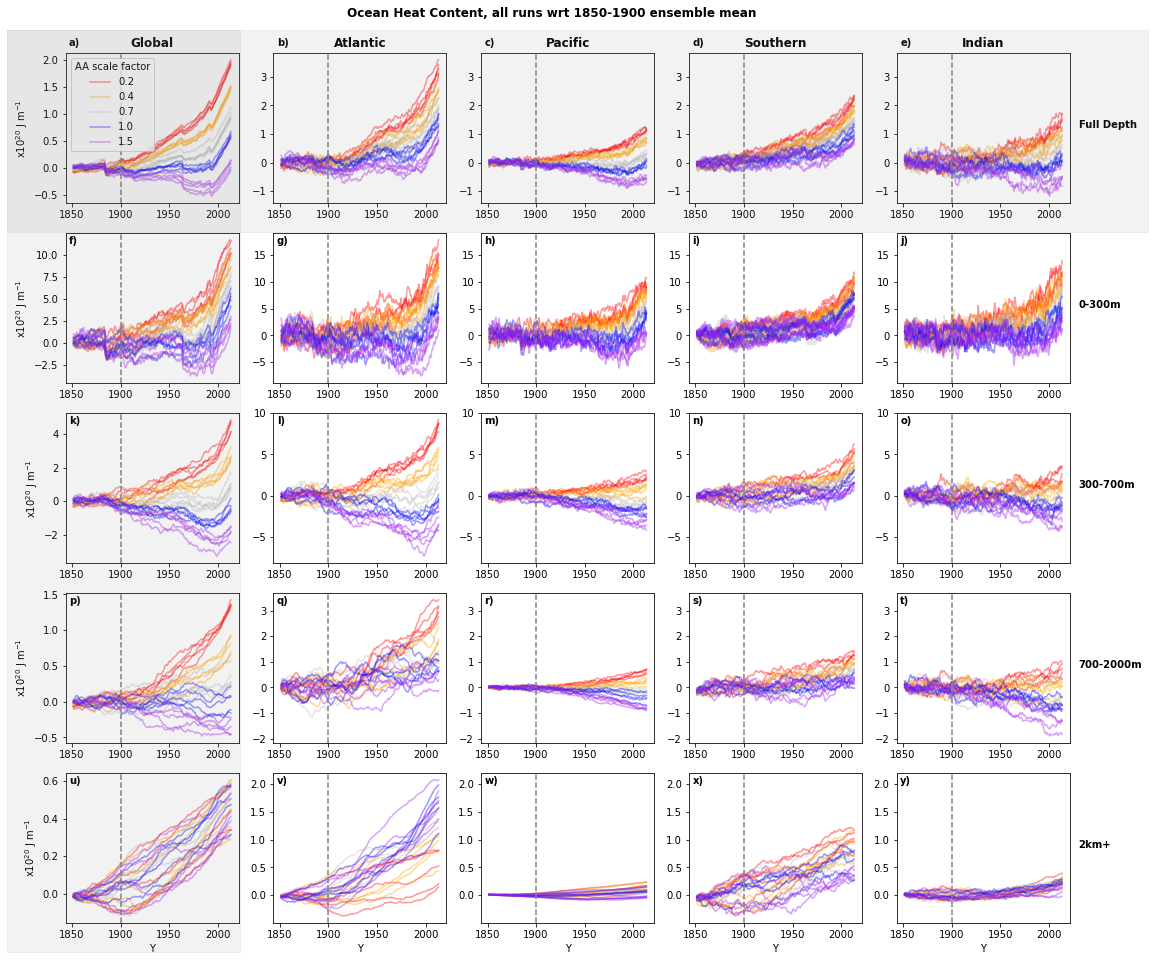

In [22]:
%matplotlib inline
dplot=ohc_all.ohc
dplot=dplot-(ohc_pic_drift*1e18*time_months)-T0_offset
dplot=(dplot-dplot.isel(time=slice(0,12*50)).mean(dim=['time','run']))/1e5
dplot_smooth=utils.butter_ufunc(dplot,filt_val,'time')
dplot_smooth=dplot_smooth.isel(time=slice(filt_val,-filt_val))

nd=dplot.lev_bins.size

fig=plt.figure(figsize=[18,16])

for id in range(nd): 
    for ib,basin in enumerate(basins):
        ax=plt.subplot(5,5,id*5+ib+1)
        lines=[]
        for ie,exp in enumerate(dplot.exp):
            for ir,run in enumerate(runs):
                dplot_line=dplot_smooth.isel(exp=ie,run=ir,basin=ib,lev_bins=id)
                line=dplot_line.plot(ax=ax,color=smurphs_cmap[ie],alpha=alpha)
            lines.append(line[0])    
        if ib == 0:
            ax.set_ylabel('x10$^{5}$ J m$^{-3}$')
            if id==0:
                ax.legend(lines,exp_names,loc='best',title='AA scale factor')
        else:
            ax.set_ylabel(' ')
        if id ==0:
            ax.set_title(basin_name[basin],{'fontweight':'bold'})
        else:
            ax.set_title('')        
        if id==4:
            ax.set_xlabel('Y')
        else:
            ax.set_xlabel('')
        if ib>1:
            ax.sharey(ax_old)
        if ib==4:
            depth=dplot.lev_bins.values[id]
            ax.text(1.05,0.5,depth,fontweight='bold',rotation=0,transform=ax.transAxes)
        if id==0:
            ax.text(0.02,1.05,'{})'.format(chr(ord('a')+ib)),fontweight='bold',transform=ax.transAxes)    
        else:
            ax.text(0.02,0.93,'{})'.format(chr(ord('a')+id*5+ib)),fontweight='bold',transform=ax.transAxes)  
        plt.axvline(cftime.date2num(cftime.Datetime360Day(1900,1,16),units='days since 2000-01-01',calendar='360_day'),color='grey',ls='--')
        ax_old=ax
        

fig.patches.extend([plt.Rectangle((0.08,0.725),0.88,0.175,
                                  fill=True, color='grey', alpha=0.1, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.08,0.1),0.18,0.80,
                                  fill=True, color='grey', alpha=0.1, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])

plt.suptitle('Ocean Heat Content, all runs wrt 1850-1900 ensemble mean',weight='bold',y=0.92)
plt.savefig(figs_dir+'Fig1_ohc_bybasindepth_allruns.png',bbox_inches='tight')

## Table 2

In [23]:
dplot=ohc_all.ohc
dplot=dplot-(ohc_pic_drift*1e18*time_months)-T0_offset
ohc_delta=(dplot.sel(time=slice('1995-01-01',None)).mean(dim='time'))-(dplot.sel(time=slice(None,'1870-01-01')).mean(dim='time'))
ohc_delta=ohc_delta/1e5/((2005-1860)/100)
ohc_delta['forc']=('exp',[0.38,0.6,0.93,1.17,1.5])

In [24]:
# Stack run and experiment dimensions to get all 25 ensemble members 
XX=ohc_delta.forc.broadcast_like(ohc_delta).stack({'run_exp':['run','exp']}).chunk({'run_exp': -1})
YY=ohc_delta.stack({'run_exp':['run','exp']}).chunk({'run_exp': -1})
stats_out=utils.lin_regress(XX,YY,[['run_exp'],['run_exp']]) #Calls a vectorised version of scipy.stats.linregress
r2=stats_out.sel(parameter='r_value')**2
r2['parameter']='r^2'
stats_out=xr.concat([stats_out,r2],'parameter')
stats_out=stats_out.compute()

In [25]:
#Create latex formatted table and write to file
nd=stats_out.lev_bins.size

with open(figs_dir+'table2.tex','w') as f:
    print('&&\\textbf{Global} & \\textbf{Atlantic} & \\textbf{Pacific} & \\textbf{Southern} & \\textbf{Indian}  \\\\',file=f)
    for id in range(0,nd):
        depth_label=stats_out['lev_bins'].values[id]
        r2=stats_out.sel(parameter='r^2').isel(lev_bins=id).data
        slopes=stats_out.sel(parameter='slope').isel(lev_bins=id).data
        errs=stats_out.sel(parameter='std_err').isel(lev_bins=id).data
        str='\\textbf{{{}}} & $R^2$ & \\textbf{{{:0.2f}}}  &  \\textbf{{{:0.2f}}}   &  \\textbf{{{:0.2f}}}   &   \\textbf{{{:0.2f}}}    &  \\textbf{{{:0.2f}}}  \\\\\
    & Slope  & ${:0.1f}\\pm{:0.1f}$& ${:0.1f}\\pm{:0.1f}$& ${:0.1f}\\pm{:0.1f}$ & ${:0.1f}\\pm{:0.1f}$ & ${:0.1f}\pm{:0.1f}$  \\\\'.format(depth_label,r2[0],r2[1],r2[2],r2[3],r2[4],slopes[0],errs[0],slopes[1],errs[1],slopes[2],errs[2],slopes[3],errs[3],slopes[4],errs[4])
        if id ==1:
            print('\\hline \\hline',file=f)
        else:
            print('\\hline',file=f)
        print(str,file=f)